### Canadian Weather Data example of DBSCAN
* Source blog: https://towardsdatascience.com/dbscan-algorithm-complete-guide-and-application-with-python-scikit-learn-d690cbae4c5d
* Source code: https://github.com/suvoooo/Machine_Learning/blob/master/DBSCAN_Complete/DBSCAN_Medium.ipynb
* Source data: https://github.com/suvoooo/Machine_Learning/blob/master/DBSCAN_Complete/weather-stations.csv


In [6]:
import numpy as np 
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Check the Matplotlib Version. It should be version 3.0.1 or above
# This code needs advanced 3D plotting using mpl_toolkits with maps
print ("Matplotlib Version", matplotlib.__version__)

Matplotlib Version 3.3.2


#### Using DBSCAN for Tasks Like Class Identification on a Spatial Context
Usually 2 parameters for DBSCAN to Optimize
1. Epsilon $\epsilon$: determines how much close the points should be to be considered a part of a cluster and 
2. MinPts: determines how many number of samples (points) need to be considered around a point within the radius $\epsilon$ to be considered as a Core Point. MinPts include the point in consideration itself.

We start with loading the Canada Weather Data-Set. We will cluster weather stations that show similar weather conditions. Selection of features and applications on clustering will be shown. Since the data domain is not so well understood, it is always best to play around with $\epsilon$ and MinPts parameter in Scikit learn.

In [4]:
import pandas as pd

weather_df = pd.read_csv('weather-stations1.csv')
print ("Shape of the DataFrame: ", weather_df.shape)
weather_df.head(3)

Shape of the DataFrame:  (1341, 25)


,Stn_Name,Lat,Long,Prov,Tm,DwTm,D,Tx,DwTx,Tn,...,DwP,P%N,S_G,Pd,BS,DwBS,BS%,HDD,CDD,Stn_No
0,CHEMAINUS,48.935,-123.742,BC,8.2,0.0,NaN,13.5,0.0,1.0,...,0.0,NaN,0.0,12.0,NaN,NaN,NaN,273.3,0.0,1011500
1,COWICHAN LAKE FORESTRY,48.824,-124.133,BC,7.0,0.0,3.0,15.0,0.0,-3.0,...,0.0,104.0,0.0,12.0,NaN,NaN,NaN,307.0,0.0,1012040
2,LAKE COWICHAN,48.829,-124.052,BC,6.8,13.0,2.8,16.0,9.0,-2.5,...,9.0,NaN,NaN,11.0,NaN,NaN,NaN,168.1,0.0,1012055


So there are 25 columns and now we need to learn more about the Columns, The names that are difficult to guess

* Stn_Name === Station Name
* Prov === Province
* Tm === Mean Temperature (°C)
* Tn === Lowest Monthly Minimum Temperature
* Tx === Highest Monthly Maximum Temperature
* DwTm === Days Without Valid Mean Temperature
* DwTx === Days Without Valid Maximum Temperature
* DwTn === Days Without Valid Minimum Temperature
* D === Mean Temperature Difference from Normal
* S === Snowfall (cm)
* DwS === Days Without Snowfall
* S%N === Percent of Normal Snowfall
* P === Total Precipitation (mm)
* DwP === Days Without Valid Precipitation
* P%N === Percent of Normal Precipitation
* Pd === No. of days with precipitation 1mm or More
* BS === Bright Sunshine days
* DwBS === Days Without valid Bright Sunshine
* BS% === Percent of Normal Bright Sunshine
* HDD === Degree Days Below $18^{\circ}$C
* CDD === Degree Days Above $18^{\circ}$C
* Stn_No === Station Number; Climate Station Identifier (1st 3 Digits==Indicate drainage basin, Last 4 Digits Sorting Alphabetically)

We can see that there are some columns that contains NaN values. One of the importnat features is Mean temperature (Tm), so we drop the rows that contain NaN values in Tm column

In [5]:
# check the nan values in the dataframe 
weather_df.isna().sum()

Stn_Name       0
Lat            0
Long           0
Prov           0
Tm            85
DwTm          85
D            984
Tx            81
DwTx          81
Tn            81
DwTn          81
S            755
DwS          755
S%N         1143
P            114
DwP          114
P%N         1132
S_G          543
Pd           114
BS          1341
DwBS        1341
BS%         1341
HDD           85
CDD           85
Stn_No         0
dtype: int64

In [7]:
weather_df.dropna(subset=['Tm', 'Tx', 'Tn'], inplace=True)
print ("After Dropping Rows that contains NaN on Mean, Max, Min Temperature Column: ", weather_df.shape)

After Dropping Rows that contains NaN on Mean, Max, Min Temperature Column:  (1255, 25)


In [8]:
# Checking if rows for blank values of Tm, Tx & Tn have been dropped
weather_df.isna().sum()

Stn_Name       0
Lat            0
Long           0
Prov           0
Tm             0
DwTm           0
D            898
Tx             0
DwTx           0
Tn             0
DwTn           0
S            744
DwS          744
S%N         1073
P            112
DwP          112
P%N         1062
S_G          522
Pd           112
BS          1255
DwBS        1255
BS%         1255
HDD            0
CDD            0
Stn_No         0
dtype: int64

### For a really nice visualisation we can use the mpl_toolkits Basemap class
#### Since these are locations in Canada we can call up the Canadian map with attributes given below

Call a Basemap class instance with Mercator projection (projection= ‘merc’), low resolution (resolution= ‘l’), and the boundaries of the map domain are given by the 4 parameters llcrnrlon, llcrnrlat, urcrnrlon, urcrnrlat, where llcrnrlon denotes longitude of lower left hand corner of the selected map domain and so on. Drawcoastlines, drawcountries do exactly what the names suggest, drawlsmask draws a high resolution land-sea mask as an image with land and ocean colors specified to orange and sky-blue. Latitude and Longitude are converted to x/y map projection coordinates using the command as given below.

In [9]:
import mpl_toolkits
mpl_toolkits.__path__.append('/usr/lib/python2.7/dist-packages/mpl_toolkits/')
from mpl_toolkits.basemap import Basemap
import matplotlib
from PIL import Image
import matplotlib.pyplot as plt
#print (matplotlib.__version__)
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

These map projection coordinates will be used as features to cluster the data points spatially along with the temperatures. First let’s take a look below the weather stations

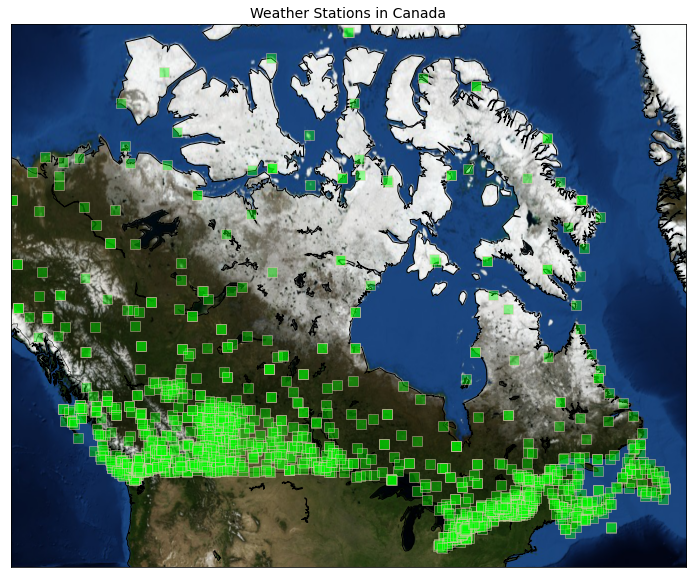

In [10]:
llon=-140
ulon=-50
llat=40
ulat=75

# selecting the boundaries of the map from lattitude and longitude 

weather_df = weather_df[(weather_df['Long'] > llon) & (weather_df['Long'] < ulon) & 
                        (weather_df['Lat'] > llat) &(weather_df['Lat'] < ulat)]



my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawlsmask(land_color='orange', ocean_color='skyblue')
#my_map.shadedrelief()
my_map.bluemarble()
# To collect data based on stations        

xs,ys = my_map(np.asarray(weather_df.Long), np.asarray(weather_df.Lat))
weather_df['xm']= xs.tolist()
weather_df['ym'] =ys.tolist()

#Visualization1
for index,row in weather_df.iterrows():
#   x,y = my_map(row.Long, row.Lat)
   my_map.plot(row.xm, row.ym,markerfacecolor ='lime',markeredgecolor='pink', marker='s', markersize= 10, alpha = 0.4)
#plt.text(x,y,stn)
plt.title("Weather Stations in Canada", fontsize=14)
plt.savefig("Canada_WS.png", dpi=300)
plt.show()

In [11]:
#my_map.drawmapboundary()
#my_map.fillcontinents(color = 'orange', alpha = 0.3)
#my_map.fillcontinents(color='#cc9955', lake_color='aqua', alpha=0.4)

In [12]:
#print (xs.tolist())
#print (ys.tolist())

### 3.1. Clustering the Weather Data (Temperatures & Coordinates as Features)

#### Clustering Weather Stations Based on Mean, Maximum and Minimum Temperature.
In the DataFrame the Variables are Tm, Tn, Tx.

First we check the distribution of the temperatures to get an rough Idea. Find the maximum, minimum of these three features to get a rough idea.

In [13]:
#print (weather_df.loc[weather_df['Tn'].idxmin()])

# Apart from the idxmax, we ca just use dataframe min max function to get the values

print ("Minimum Mean temperature: ", weather_df['Tm'].min())
print ("Minimum Max Temperature: ", weather_df['Tx'].min())
print ("Maximun Min Temperature: ", weather_df['Tn'].max())

Minimum Mean temperature:  -37.0
Minimum Max Temperature:  -28.9
Maximun Min Temperature:  5.3


We can look at more cool visualisations of temperature across different weather stations as histograms & also the really nice violin plots.

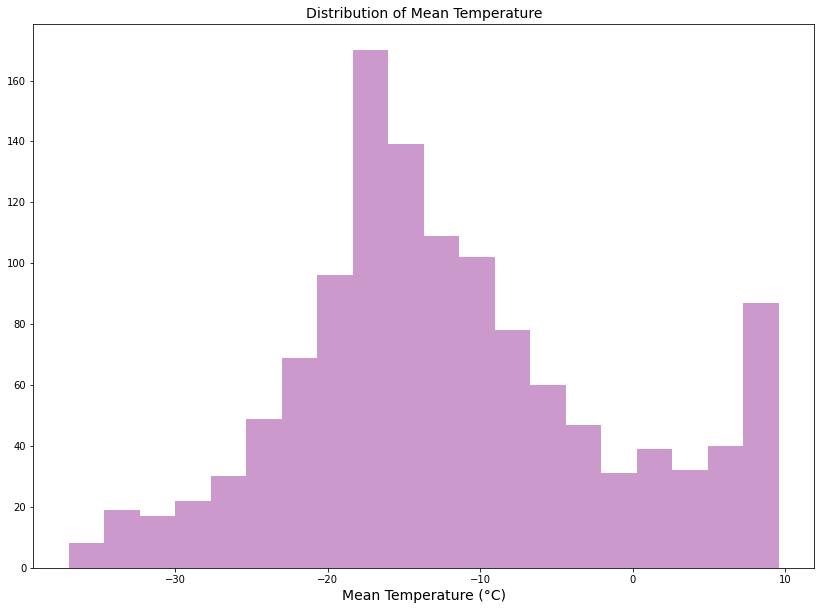

In [14]:
import seaborn as sns

sns.distplot(weather_df['Tm'], color='purple', kde=False)
plt.xlabel('Mean Temperature (°C)', fontsize=14)
plt.title('Distribution of Mean Temperature', fontsize=14)
#plt.savefig("Dist_of_Mean_Temp.png",dpi=200)
plt.show()

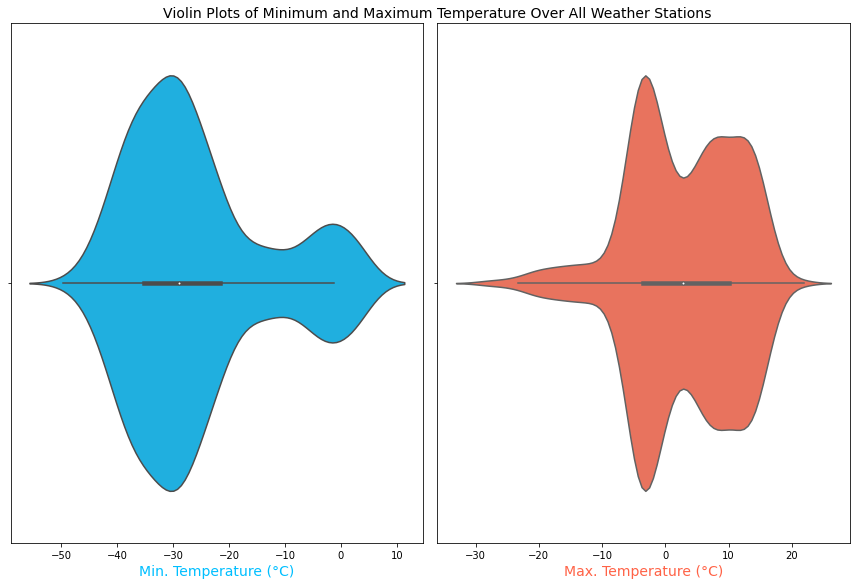

In [15]:
# Violin Plots of Minimum and Maximum Temperature
fig = plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.violinplot(x=weather_df["Tn"], color='deepskyblue')
plt.xlabel("Min. Temperature (°C)", fontsize=14, color='deepskyblue')
plt.subplot(1,2,2)
sns.violinplot(x=weather_df["Tx"], color='tomato')
plt.xlabel("Max. Temperature (°C)", fontsize=14, color='tomato')
plt.tight_layout()
plt.title("Violin Plots of Minimum and Maximum Temperature Over All Weather Stations", fontsize=14, x=-0.0)
plt.savefig("Violin_Plots_Min_Max_Temp.png", dpi=200)
plt.show()

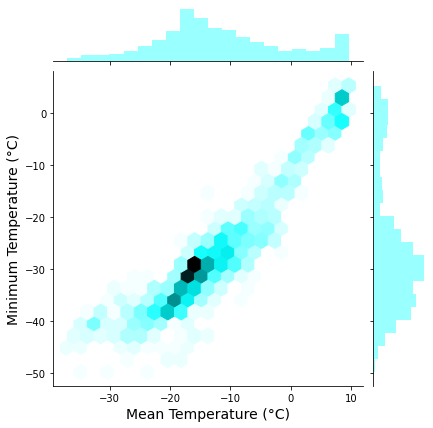

In [16]:
# Joint Plot of Mean Temperature and Minimum Temperature
g=sns.jointplot(x=weather_df['Tm'], y=weather_df['Tn'], kind='hex', color='cyan')
g.set_axis_labels("Mean Temperature (°C)","Minimum Temperature (°C)", fontsize=14)
plt.savefig("Hex_Tm_Tn.png", dpi=200)
plt.show()

#### Proceed To Clustering using DBSCAN
Choosing temperatures (‘Tm’, ‘Tx’, ‘Tn’) and x/y map projections of coordinates (‘xm’, ‘ym’) as features and, setting ϵ and MinPts to 0.3 and 10 respectively, gives 8 unique clusters (noise is labeled as -1). You can change these parameters to test how much clustering is affected accordingly.

After that we can visualize these clusters using Basemap:

In [17]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
weather_df_clus_temp = weather_df[["Tm", "Tx", "Tn", "xm", "ym"]]
weather_df_clus_temp = StandardScaler().fit_transform(weather_df_clus_temp)

db = DBSCAN(eps=0.3, min_samples=10).fit(weather_df_clus_temp)
labels = db.labels_
print (labels[500:560])
weather_df["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels))

[ 4  4  4  4  4  4  4  4  4  3  4  3  4  3  4  4  4  4  4  4  4  4  4  4
  4  4 -1  4  4  4 -1  4 -1  3 -1  4 -1  3  3  3  3  3  3  3  3  3  3  3
 -1 -1  3  3  3  3 -1  3  3  3  3  3]


In [18]:
set(labels)

{-1, 0, 1, 2, 3, 4, 5, 6, 7}

#### Plot the Clusters in the Map.

Cluster 0, Average Mean Temp: 6.2406779661016945
Cluster 1, Average Mean Temp: -0.5523809523809524
Cluster 2, Average Mean Temp: -3.244444444444445
Cluster 3, Average Mean Temp: -13.733725490196077
Cluster 4, Average Mean Temp: -4.153703703703704
Cluster 5, Average Mean Temp: -16.401294498381876
Cluster 6, Average Mean Temp: -10.08421052631579
Cluster 7, Average Mean Temp: -4.706250000000001


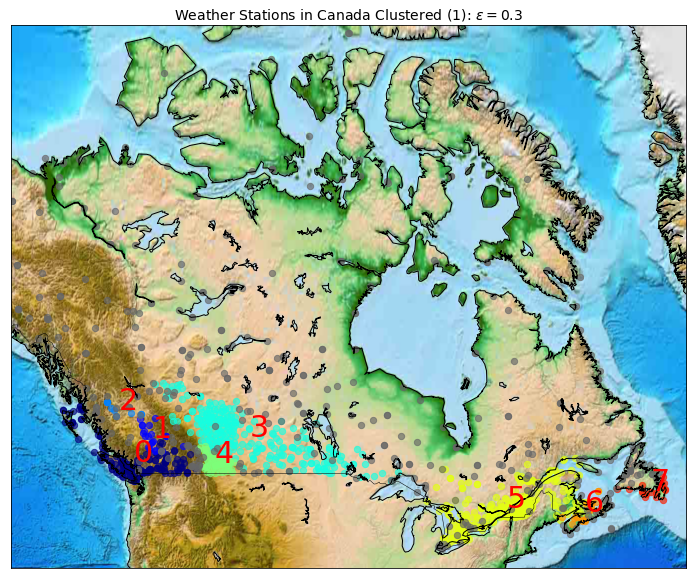

In [20]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
#my_map.drawmapboundary()
#my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.drawlsmask(land_color='orange', ocean_color='skyblue')
#my_map.shadedrelief()
#my_map.bluemarble()
#my_map.shadedrelief()
my_map.etopo()

# To create a color map
colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))



#Visualization1
for clust_number in set(labels):
    c=(([0.4,0.4,0.4]) if clust_number == -1 else colors[np.int(clust_number)])
    clust_set = weather_df[weather_df.Clus_Db == clust_number]                    
    my_map.scatter(clust_set.xm, clust_set.ym, color =c,  marker='o', s= 40, alpha = 0.65)
    if clust_number != -1:
        cenx=np.mean(clust_set.xm) 
        ceny=np.mean(clust_set.ym) 
        plt.text(cenx,ceny,str(clust_number), fontsize=30, color='red',)
        print ("Cluster "+str(clust_number)+', Average Mean Temp: '+ str(np.mean(clust_set.Tm)))
plt.title(r"Weather Stations in Canada Clustered (1): $ \epsilon = 0.3$", fontsize=14)        
plt.savefig("etopo_cluster.png", dpi=300)

### Repeat The Process One More Time Including Precipitation as Feature

Now include precipitation (‘P’) in the features and repeat the same clustering steps with ϵ and MinPts set to 0.5 and 10. We see some differences from the previous clustering and, thus it gives us an idea about problem of clustering unsupervised data even using DBSCAN when we lack the domain knowledge.

In [21]:
# stop the SettingWithCopyWarning: 
pd.options.mode.chained_assignment = None  # default='warn'
#

from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
weather_df_copy = weather_df.copy()
weather_df_clus_temp_P = weather_df_copy[["Tm", "Tx", "Tn", "xm", "ym", "P"]]

weather_df_clus_temp_P.dropna(subset=["Tm", "Tx", "Tn", "xm", "ym", "P"], inplace=True)
print ("After Dropping Rows that contains NaN on Precipitation Column: ", weather_df_clus_temp_P.shape)

print (weather_df_clus_temp_P.head(6))

After Dropping Rows that contains NaN on Precipitation Column:  (1136, 6)
    Tm    Tx   Tn            xm            ym      P
0  8.2  13.5  1.0  1.807806e+06  1.396332e+06  178.8
1  7.0  15.0 -3.0  1.764329e+06  1.377564e+06  258.6
2  6.8  16.0 -2.5  1.773336e+06  1.378409e+06  264.6
4  7.7  14.5 -1.0  1.809363e+06  1.362546e+06  168.4
5  8.8  13.1  1.9  1.841498e+06  1.311615e+06   81.0
6  8.9  13.5  2.0  1.826598e+06  1.404800e+06  110.0


In [22]:
#print (weather_df_clus_temp.shape)
weather_df_clus_temp_P_arr = weather_df_clus_temp_P[["Tm", "Tx", "Tn", "xm", "ym", "P"]]
weather_df_clus_temp_P_arr = StandardScaler().fit_transform(weather_df_clus_temp_P_arr)

db_P = DBSCAN(eps=0.5, min_samples=10).fit(weather_df_clus_temp_P_arr)
# # create an array of zeroes of same size as db.labels_. db.labels_ is an array containing labels for 
labels_P = db_P.labels_
print(labels_P[500:560])
print (labels_P.dtype)
#print(np.isnan(labels_P).any())
weather_df_clus_temp_P["Clus_Db_"]=labels_P

[ 1  1  1 -1 -1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1  1 -1
 -1 -1  1 -1 -1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1]
int64


In [23]:
weather_df_clus_temp_P.head(6)

,Tm,Tx,Tn,xm,ym,P,Clus_Db_
0,8.2,13.5,1.0,1.807806e+06,1.396332e+06,178.8,0
1,7.0,15.0,-3.0,1.764329e+06,1.377564e+06,258.6,-1
2,6.8,16.0,-2.5,1.773336e+06,1.378409e+06,264.6,-1
4,7.7,14.5,-1.0,1.809363e+06,1.362546e+06,168.4,0
5,8.8,13.1,1.9,1.841498e+06,1.311615e+06,81.0,0
6,8.9,13.5,2.0,1.826598e+06,1.404800e+06,110.0,0


In [24]:
realClusterNum_P=len(set(labels_P)) - (1 if -1 in labels_P else 0)
clusterNum_P = len(set(labels_P)) 


print (set(labels_P))

{0, 1, 2, 3, -1}


Cluster 0, Average Mean Temp: 7.680246913580247
Cluster 0, Average Mean Precipitation: 126.10000000000002
Cluster 1, Average Mean Temp: -12.53424283765348
Cluster 1, Average Mean Precipitation: 27.415006821282404
Cluster 2, Average Mean Temp: -26.142857142857135
Cluster 2, Average Mean Precipitation: 8.7
Cluster 3, Average Mean Temp: -10.406666666666666
Cluster 3, Average Mean Precipitation: 146.02333333333334


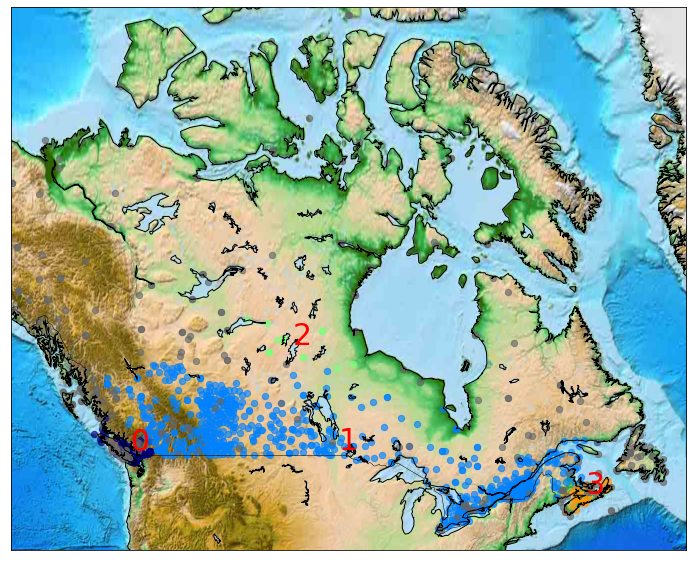

In [25]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

my_map1 = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map1.drawcoastlines()
my_map1.drawcountries()
#my_map.drawmapboundary()
#my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map1.drawlsmask(land_color='orange', ocean_color='skyblue')
#my_map.shadedrelief()
#my_map.bluemarble()
#my_map.shadedrelief()
my_map1.etopo()

# To create a color map
colors1 = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum_P))



#Visualization1
for clust_number_P in set(labels_P):
    c=(([0.4,0.4,0.4]) if clust_number_P == -1 else colors1[np.int(clust_number_P)])
    clust_set_P = weather_df_clus_temp_P[weather_df_clus_temp_P.Clus_Db_ == clust_number_P]                    
    my_map.scatter(clust_set_P.xm, clust_set_P.ym, color =c,  marker='o', s= 40, alpha = 0.65)
    if clust_number_P != -1:
        cenx=np.mean(clust_set_P.xm) 
        ceny=np.mean(clust_set_P.ym) 
        plt.text(cenx,ceny,str(clust_number_P), fontsize=30, color='red',)
        print ("Cluster "+str(clust_number_P)+', Average Mean Temp: '+ str(np.mean(clust_set_P.Tm)))
        print ("Cluster "+str(clust_number_P)+', Average Mean Precipitation: '+ str(np.mean(clust_set_P.P)))
plt.savefig("etopo_cluster_preci.png", dpi=300)

You can try to repeat the process including some more features, or, change the clustering parameters, to get a better overall knowledge.